# Plot a vertical cross section from CAM
# Using DASK

Author: Brian Medeiros (brianpm@ucar.edu)
With contributions from: Jennifer Kay (Jennifer.E.Kay@colorado.edu)

We start from a CAM history file(s) or timeseries file(s). 
We convert from the native CAM vertical grid to fixed pressure levels.
Then, we plot an atmospheric cross-section. Specifically, we make a plot showing temperature contours (color shading) and zonal wind speed (contour lines). We also add functionality to extract a specific time period and to focus on a specific zonal mean set using minlat/maxlat.

In [47]:
# libraries
from pathlib import Path 
import numpy as np
import xarray as xr
import Ngl
import matplotlib as mpl
import matplotlib.pyplot as plt
from os import listdir 
from datetime import datetime as dt

use_dask="yes"
if use_dask=="yes":
    # libraries (from cesm-le-seaice-example.ipynb)
    import os
    from glob import glob
    import cftime
    from itertools import product, chain
    import pandas as pd
    import dask
    import esmlab
    from ncar_jobqueue import NCARCluster
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    print("I'm using dask - This should go fast!")

I'm using dask - This should go fast!


In [48]:
# it's probably worth taking a look at the versions
import sys
print(f"python version {sys.version}")
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"xarray version: {xr.__version__}")
print(f"PyNgl version: {Ngl.__version__}")

python version 3.7.3 | packaged by conda-forge | (default, Mar 27 2019, 23:01:00) 
[GCC 7.3.0]
numpy version: 1.16.4
matplotlib version: 3.1.0
xarray version: 0.12.1
PyNgl version: 1.6.1


In [49]:
###############################################################
### NOTE: ALL USER INPUT SHOULD BE PUT IN HERE IN THIS CELL ###
###############################################################

## Set the CAM data_type and the location of the CAM files 
data_type="ts"  ## "ts" (post-processed timeseries), "hist" (CAM history files)
month_to_plot_start='0100-01' #YYYY-MM start
month_to_plot_end='0109-12'   #YYYY-MM end; set equal to start for one month
minlat=-90
maxlat=90

## Specify the case-specific directory and name
if data_type=="ts":
    ### Sample case names for "ts"
    cname="b.e11.B1850C5CN.f09_g16.005_0.5xCO2"
    allruns_dir="/gpfs/fs1/p/cesm/pcwg/jenkay/chalmers/"
    #cname="f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001"
    #allruns_dir="/glade/collections/cdg/timeseries-cmip6/"
if data_type=="hist":
    ### Sample case names for "hist"
    cname="cesm2_f2000_default"
    allruns_dir="/glade/scratch/brianpm/archive/"
    #cname="qpc6_control"
    #allruns_dir="/Volumes/project/amp/brianpm/aquadeck/"

Here we'll request the resources using dask... only if use_dask=="yes"

In [79]:
if use_dask=="yes":
    ## Spin up a dask cluster

    ## First you define one job 
    ## e.g., default here (processes=1 (keep at 1 for plotting) ; cores=36)
    cluster = PBSCluster(cores=36, memory='45GB', processes=1, project='NCGD0045',
                         queue='S6408235', walltime='01:00:00',
                        resource_spec='select=1:ncpus=36:mem=45GB')
    ## each dask worker has this number of cores (also called threads) = 36 / processes
    ## dask workers (processes) = 1
    ## cheyenne_nodes = 1

    ## Second you scale it up to many jobs
    ## Rule of thumb - use a factor of #processes (same as #nodes)
    nprocesses=1
    ndaskworkers=2  ## this is your scale factor (2=default)
    cluster.scale(nprocesses*ndaskworkers) 
    ## each dask worker has this number of threads (cores) = 36 / processes
    ## dask workers (processes) = nprocesses*ndaskworkers
    ## cheyenne_nodes = 2 (on each node, you have a dask worker/processor)
    print(cluster)

PBSCluster(cores=0, memory=0 B, workers=0/0, jobs=0/0)


/glade/u/home/jenkay/miniconda3/envs/analysis_pyngl/lib/python3.7/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "
/glade/u/home/jenkay/miniconda3/envs/analysis_pyngl/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [105]:
## print the job script that it will actually submit
print(cluster.job_script())

#!/bin/bash

#!/usr/bin/env bash
#PBS -N dask-worker
#PBS -q S6408235
#PBS -A NCGD0045
#PBS -l select=1:ncpus=36:mem=45GB
#PBS -l walltime=01:00:00
#PBS -o /glade/scratch/jenkay/
#PBS -e /glade/scratch/jenkay/
JOB_ID=${PBS_JOBID%.*}



/glade/u/home/jenkay/miniconda3/envs/analysis_pyngl/bin/python -m distributed.cli.dask_worker tcp://10.148.0.41:43077 --nthreads 36 --memory-limit 45.00GB --name dask-worker--${JOB_ID}-- --death-timeout 60 --local-directory /glade/scratch/jenkay/dask-tmp --interface ib0 --interface ib0 --interface ib0 --interface ib0 --interface ib0



In [80]:
if use_dask=="yes":
    ## request client
    client = Client(cluster) # Connect this local process to remote workers
    print(client)
    print(cluster.dashboard_link)

<Client: scheduler='tcp://10.148.0.41:43077' processes=0 cores=0>


Client Scheduler: tcp://10.148.0.41:43077 Dashboard: http://10.148.0.41/proxy/48331/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [81]:
## Check the queue.  Note that using '!' makes you able to execute text at the command line
!qstat -u jenkay

## Caution - Until your cluster is ready - Do not operate the rest of the code...

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
/usr/bin/sh: ml: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_ml'

chadmin1: 
                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
6477944.chadmin jenkay   S6408235 Jupyter     43968   1   1    --  03:00 R 01:42
6480140.chadmin jenkay   S6408235 dask-worke  58289   1  36   45gb 01:00 R 00:00
6480141.chadmin jenkay   S6408235 dask-worke  46219   1  36   45gb 01:00 R 00:00
6480143.chadmin jenkay   S6408235 dask-worke  52378   1  36   45gb 01:00 R 00:00
6480144.chadmin jenkay   S6408235 dask-worke  52904   1  36   45gb 01:00 R 00:00


In [45]:
##kills the cluster -- you might want to do this if you are waiting in the queue forever due to a set-up issue
#cluster.close()  
#client.close()

The only hard part for making a pressure-latitude (or pressure by whatever) plot is to convert from the model's hybrid-sigma coordinate to a pressure coordinate. The following function, `use_vinth2p`, is one way to do this vertical interpolation. It uses PyNgl's `vinth2p` function, which is a thin wrapper around a 1-d interpolation routine written in Fortran.

In [82]:
## find the time
ta=dt.now()

In [83]:
# Set up a function to do the vertical interpolation from the CAM hybrid to pressure levels.
# Here we'll use NCL legacy code.
# Note: The Ngl vertical interpolation is substantially faster than other python implementations,
# even though it is not as "pythonic" looking as some others.
def use_vinth2p(x_mdl, psfc, hya, hyb, pnew_hPa, p0=1000., interp=1, extrap=False):
    """Interpolate field x_mdl from hybrid levels to pressure levels given by pnew_hPa."""
    arr = Ngl.vinth2p(x_mdl, hya, hyb, pnew_hPa, psfc, interp, p0, 1, extrap)
    if arr is None:
        print(psfc)
    print(f"interpolation produces array of shape {arr.shape}")
    # wrap into xarray by making a new coordinate (plev) and put arr into DataArray
    plev = xr.DataArray(pnew_hPa, coords=[pnew_hPa], dims=['plev'], attrs={'units': 'hPa'})
    new_coords = []
    orig_coords = x_mdl.dims
    for c in orig_coords:
        if c == 'lev':
            new_coords.append((c, plev))
        else:
            new_coords.append((c, x_mdl[c]))
    Xp_xr = xr.DataArray(arr, coords=new_coords, attrs=x_mdl.attrs)
    Xp_xr.name = x_mdl.name
    return Xp_xr

## Data loading

Probably the 2nd hardest thing about this task is that we could be dealing with any number of possible permutations of the data. The most common cases are:
- native CAM history files (e.g., one-file-per-month with many variables)
- post-processed time series files (e.g., one or many files with one variable in each file)
- CMIP-like files, which are time series files that have been converted with CMIP variable names and other metadata.

In [84]:
## Find the data directory
# NOTE: Path is part of the standard library, and makes constructing and dealing with paths very easy.
if data_type=="ts":
    data_dir = Path(allruns_dir+cname+"/atm/proc/tseries/month_1")
    #data_dir = Path("/glade/collections/cdg/timeseries-cmip6/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001/atm/proc/tseries/month_1")
    print(data_dir)      
# CAM history files
if data_type=="hist":
    data_dir = Path(allruns_dir+casename+"atm/hist")
    # data_dir = Path("/Volumes/project/amp/brianpm/aquadeck/qpc6_control/atm/hist")
    print(data_dir)

/gpfs/fs1/p/cesm/pcwg/jenkay/chalmers/b.e11.B1850C5CN.f09_g16.005_0.5xCO2/atm/proc/tseries/month_1


In [85]:
## Read in the variables of interest
variables = ["RELHUM","U", "T", "PS"]

if data_type=="ts":
    # Time series files
    list_of_vars = variables
    list_of_das = list()
    for v in list_of_vars:
        filename = list(data_dir.glob(f"*.{v}.*"))
        filename = filename[0]
        #print(f"file name is {filename}") ## example of an f string, check this out as a tool!!
        dstmp = xr.open_dataset(filename,chunks={'time':1},decode_times=False)  ## chunking each time
        list_of_das.append(dstmp[v]) 
        if v=='RELHUM': list_of_das.append(dstmp["hyam"])
        if v=='RELHUM': list_of_das.append(dstmp["hybm"])  
        if v=='RELHUM': list_of_das.append(dstmp["time_bnds"])     
    ## combine this together into an xarray structure called ds so that the rest of the code works...
    # [print(x.name) for x in list_of_das]
    ds = xr.merge(list_of_das)

if data_type=="hist":
    # For native CAM history files:construct the ordered list of files:
    fils = sorted(list(data_dir.glob('*.cam.h0.*.nc')))
    ds = xr.open_mfdataset(fils, decode_cf=False)    

In [86]:
ds
## check that it has chunksize of 1 time

<xarray.Dataset>
Dimensions:    (lat: 192, lev: 30, lon: 288, nbnd: 2, time: 1800)
Coordinates:
  * lev        (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) float64 31.0 59.0 90.0 ... 5.469e+04 5.472e+04 5.475e+04
Dimensions without coordinates: nbnd
Data variables:
    RELHUM     (time, lev, lat, lon) float32 dask.array<shape=(1800, 30, 192, 288), chunksize=(1, 30, 192, 288)>
    hyam       (lev) float64 dask.array<shape=(30,), chunksize=(30,)>
    hybm       (lev) float64 dask.array<shape=(30,), chunksize=(30,)>
    time_bnds  (time, nbnd) float64 dask.array<shape=(1800, 2), chunksize=(1, 2)>
    U          (time, lev, lat, lon) float32 dask.array<shape=(1800, 30, 192, 288), chunksize=(1, 30, 192, 288)>
    T          (time, lev, lat, lon) float32 dask.array<shape=(1800, 30, 192, 288), chu

In [87]:
# CAM gotcha: The time is written at the END of the averaging period,
# So here, we "correct" the "time" coordinate so that the month doesn't think it is the next month
# Instead the time is now the middle of the month, which is not the CAM default but very convenient for analysis
time_bnds = ds['time_bnds']
ds['time'].values = time_bnds.mean(dim='nbnd')
ds = xr.decode_cf(ds)
#print(ds['time']) # note: this would be one month later if we didn't correct with time_bnds

In [88]:
# Make a dictionary - keys are the name of the variables; data are the data array
#variables = ["RELHUM","U", "T", "PS"]
var_arrs = {v: ds[v] for v in variables}
# allow lazy loading at this point, so should be fast.

In [89]:
## NOTE: We need to make sure that we make hyam/hybm 1-dimensional, or vinth2p may fail silently.
if 'hyam' in ds:
    if 'time' in ds['hyam'].dims:
        hyam = ds['hyam'].isel(time=0).compute()
        hybm = ds['hybm'].isel(time=0).compute()
    else:
        hyam = ds['hyam'].compute()
        hybm = ds['hybm'].compute()

In [90]:
## Complete temporal and spatial subset of the data
## Idea here is to make the interpolation faster by reducing the array size first
## Here we are just picking a range of months and the lat range selected by minlat, laxlat

#subset = {v: var_arrs[v].sel(time = slice('0002-01','0002-01'), lat = slice(minlat, maxlat)) for v in var_arrs}
subset = {v: var_arrs[v].sel(time = slice(month_to_plot_start, month_to_plot_end), lat = slice(minlat, maxlat)) for v in var_arrs}

## **too add later** -- make the temporal subset look at multiple months!!  
## we will do the interpolation on the monthly data, and then we will need to average before plotting.
# subset = {v: var_arrs[v].sel(time = slice('1980-01-01', '1989-12-01'), lat = slice(-90, 0)) for v in var_arrs}

In [91]:
#ds.time

In [92]:
#subset

In [93]:
# Define the pressure levels we want to use.
pnew = np.linspace(100, 1000, 19)  # hPa for vinth2p
print(pnew)

[ 100.  150.  200.  250.  300.  350.  400.  450.  500.  550.  600.  650.
  700.  750.  800.  850.  900.  950. 1000.]


In [94]:
# this is where we do the business
# keys that are the variable name
# values are the DataArray interpolated to pressure levels

# dictionary comprehension version
# on_p = {v: (use_vinth2p(v, subset["PS"], hyam, hybm, pnew)).squeeze() for v in ["U", "T"]}

# expanded version:
on_p = dict()
for v in ["U", "T"]:
    print(f"Working on variable: {v}")
    print(subset[v])
    on_p[v] = (use_vinth2p(subset[v], subset["PS"], hyam, hybm, pnew, p0=1000., interp=1, extrap=True)).squeeze()
    

Working on variable: U
<xarray.DataArray 'U' (time: 120, lev: 30, lat: 192, lon: 288)>
dask.array<shape=(120, 30, 192, 288), dtype=float32, chunksize=(1, 30, 192, 288)>
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 0100-01-16 12:00:00 ... 0109-12-16 12:00:00
Attributes:
    mdims:         1
    units:         m/s
    long_name:     Zonal wind
    cell_methods:  time: mean
interpolation produces array of shape (120, 19, 192, 288)
Working on variable: T
<xarray.DataArray 'T' (time: 120, lev: 30, lat: 192, lon: 288)>
dask.array<shape=(120, 30, 192, 288), dtype=float32, chunksize=(1, 30, 192, 288)>
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06

In [95]:
# take the mean in time and longitude
answer = {v: on_p[v].mean(dim=('time','lon')) for v in on_p}

### need to write logic so that if you have one month - you do not average over 'time' ##TO DO JEN

# Plot
 
We now have the variables interpolated to pressure levels. All we need to do is plot what we want.

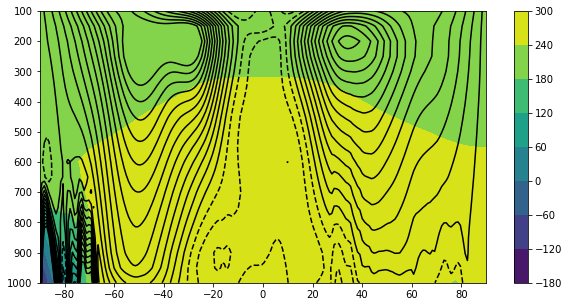

In [96]:
fig, ax = plt.subplots(figsize=(10,5))
lats, levs = np.meshgrid(answer['T']['lat'], answer['T']['lev'])
im = ax.contourf(lats, levs, answer['T'])
wind = ax.contour(lats, levs, answer['U'], levels=np.linspace(-25, 25, 26), colors='black')
ax.invert_yaxis()
fig.colorbar(im)

## Nothing's ever that easy
The interpolation doesn't seem to handle missing data correctly in this instance. Turning on the extrapolation at least provides some "reasonable" values, but we typically do not want to have values that are under Antarctica's surface. We can go back to the interpolated data and mask any values that are below the actual surface pressure, and then compare the resulting plot.

In [97]:
# but let's try to remove the spurious points
t_tmp = on_p['T']
u_tmp = on_p['U']
for k, level in enumerate(pnew):
    t_tmp[:,k,:,:] = np.where(subset['PS']/100. < level, np.nan, t_tmp[:,k,:,:])
    u_tmp[:,k,:,:] = np.where(subset['PS']/100. < level, np.nan, u_tmp[:,k,:,:])
    

/glade/u/home/jenkay/miniconda3/envs/analysis_pyngl/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


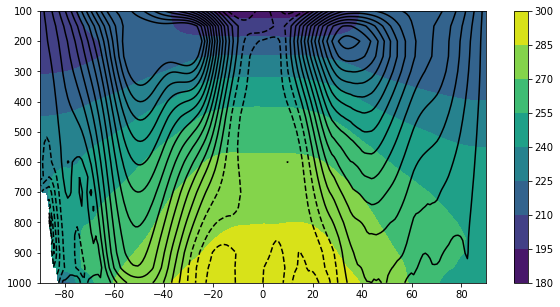

In [98]:
fig2, ax2 = plt.subplots(figsize=(10,5))
im2 = ax2.contourf(lats, levs, t_tmp.mean(dim=('time','lon')))
wind2 = ax2.contour(lats, levs, u_tmp.mean(dim=('time','lon')), levels=np.linspace(-25, 25, 26), colors='black')
ax2.invert_yaxis()
fig2.colorbar(im2)

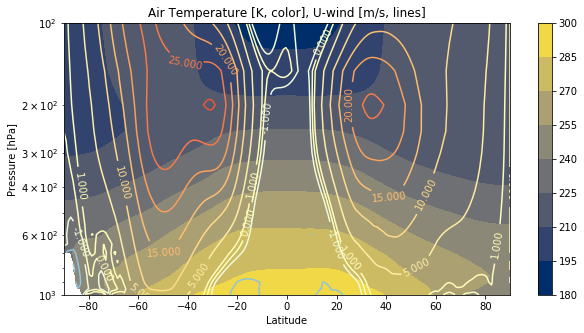

In [108]:
# cosmetics
fig2, ax2 = plt.subplots(figsize=(10,5))
im2 = ax2.contourf(lats, levs, t_tmp.mean(dim=('time','lon')), cmap='cividis')

divnorm = mpl.colors.DivergingNorm(vmin=-10., vcenter=0, vmax=45.)


wind2 = ax2.contour(lats, levs, u_tmp.mean(dim=('time','lon')), 
                    levels=[-10, -5, -1, 0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45], 
                    norm=divnorm, cmap='RdYlBu_r')
ax2.set_yscale("log") 
ax2.invert_yaxis()
ax2.set_title("Air Temperature [K, color], U-wind [m/s, lines]")
ax2.set_xlabel("Latitude")
ax2.set_ylabel("Pressure [hPa]")
ax2.clabel(wind2, inline=1, fontsize=10)
fig2.colorbar(im2)

In [100]:
totaltime=dt.now()-ta
print(totaltime)

0:00:46.927109


In [101]:
### When you are done with your cluster - close it!
if use_dask=="yes":
    cluster.close()
    client.close()